In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import tessreduce as tr

from astropy.io import fits
from astropy.wcs import WCS

In [3]:
ra = 120.71591755
dec = 45.36555112

In [53]:
tess = tr.tessreduce(ra=ra,dec=dec,sector=20,calibrate=True,plot=False)

getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is above -30 dec, calibrating to PS1 photometry.


In [9]:
wcs = tess.wcs

In [14]:
ys = tess.shift[:,0]
xs = tess.shift[:,1]

In [49]:
j = 1000
new = wcs.to_header()
new['CRPIX1'] -= ys[j]
new['CRPIX2'] -= xs[j]

In [51]:
WCS(new)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 120.72097533459 45.370219977742 
CRPIX : 45.25094030354139 45.237696983185046 
PC1_1 PC1_2  : -0.0054727311547463 -0.0014407032148012 
PC2_1 PC2_2  : 0.0015867103346302 -0.0055141040970578 
CDELT : 1.0 1.0 
NAXIS : 0  0

In [16]:
from reproject import reproject_interp
array, footprint = reproject_exact(sou, hdu1.header)

<IPython.core.display.Javascript object>


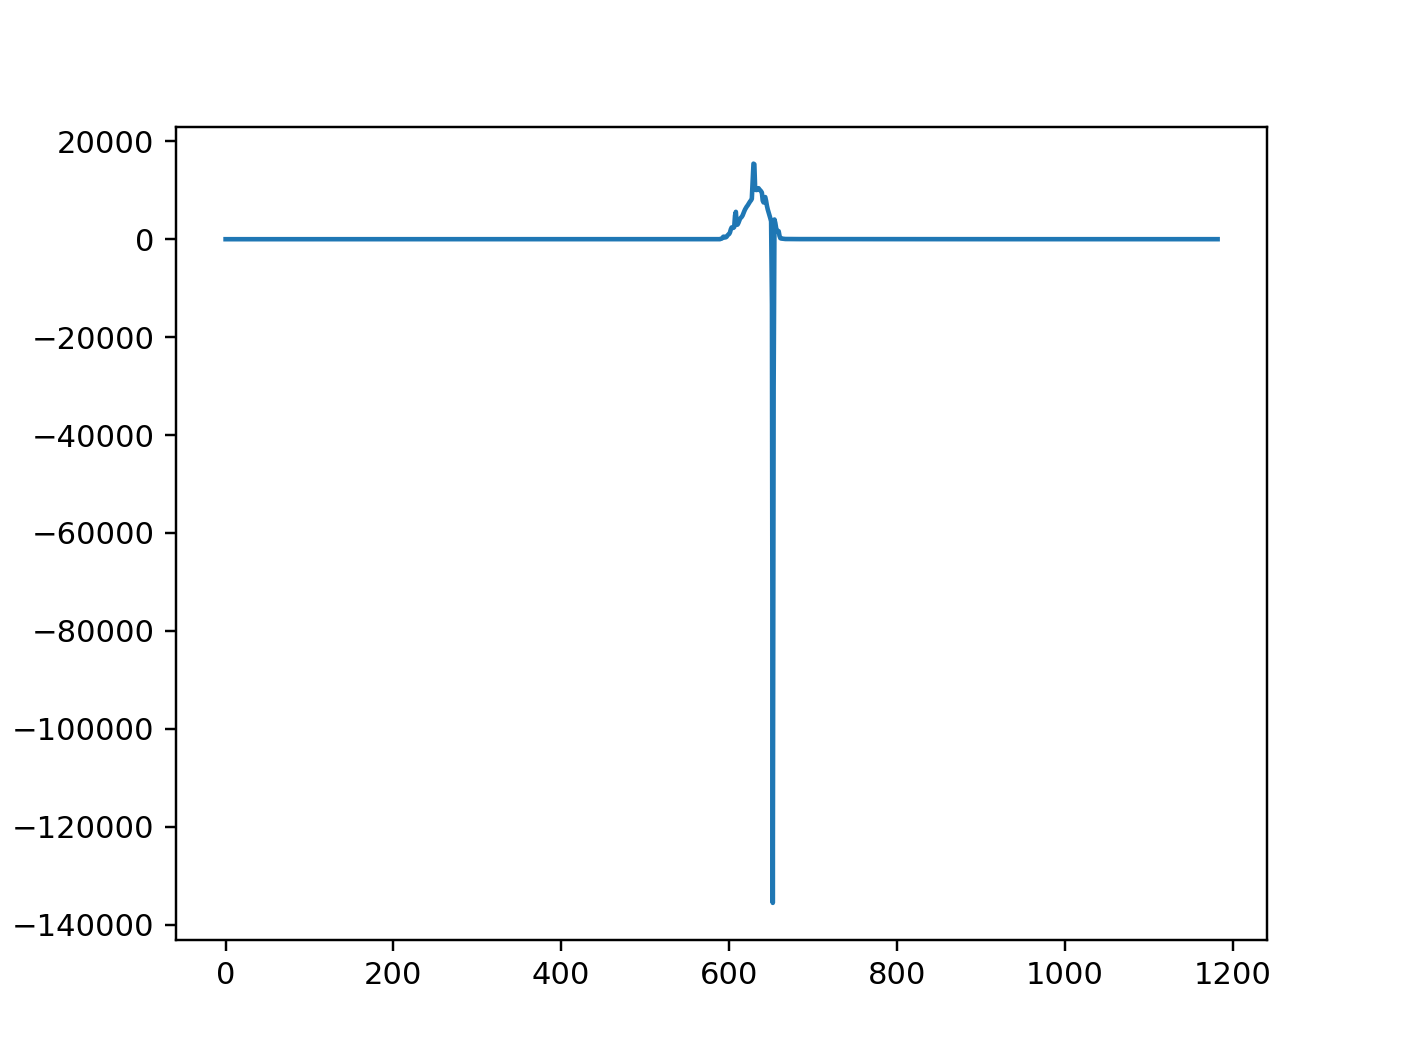

In [42]:
plt.figure()
plt.plot(tess.bkg[:,45,45])

In [43]:
tess.ref_ind

60

In [46]:
j = 1000
target = tess.tpf.flux.value[tess.ref_ind]
source = tess.tpf.flux.value[j]
comparison = tess.flux[j]
registered_image, footprint = aa.register(img_as_float64(source), img_as_float64(target))

<IPython.core.display.Javascript object>


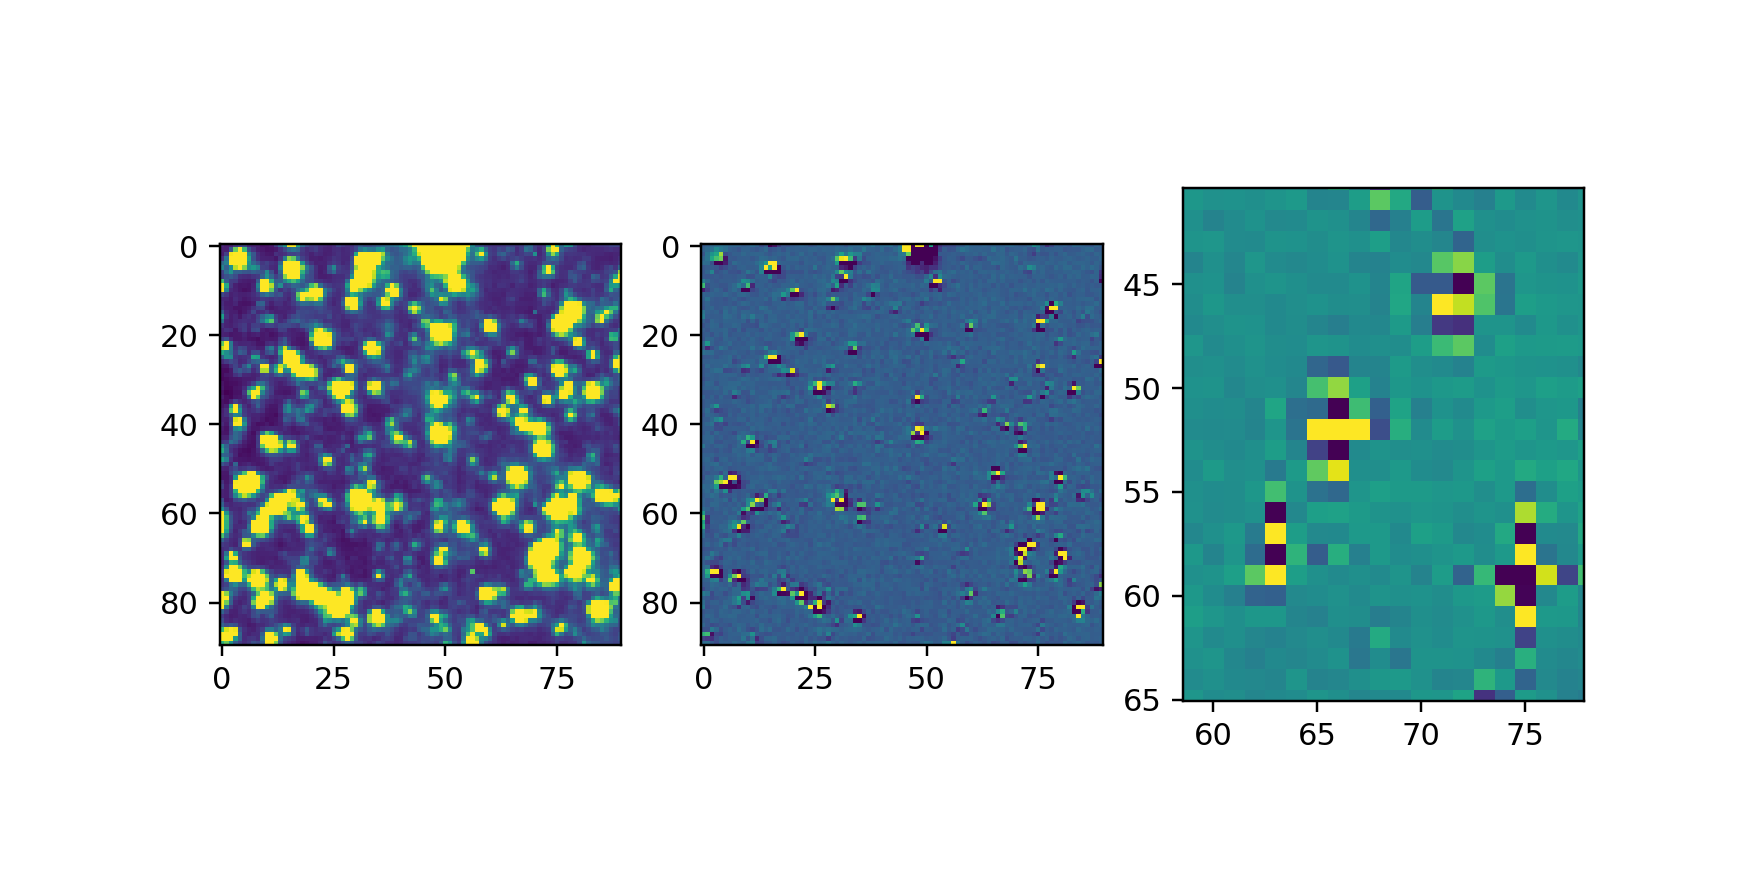

In [47]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(target,vmax=150)
plt.subplot(132)
plt.imshow(target-registered_image,vmin=-10,vmax=10)
plt.subplot(133)
plt.imshow(comparison,vmin=-10,vmax=10)

In [19]:
transf, (source_list, target_list) = aa.find_transform(source, target)

In [28]:
from skimage.util import img_as_float64

In [31]:
registered_image,mask = aa.apply_transform(transf, img_as_float64(source), img_as_float64(target))

<IPython.core.display.Javascript object>


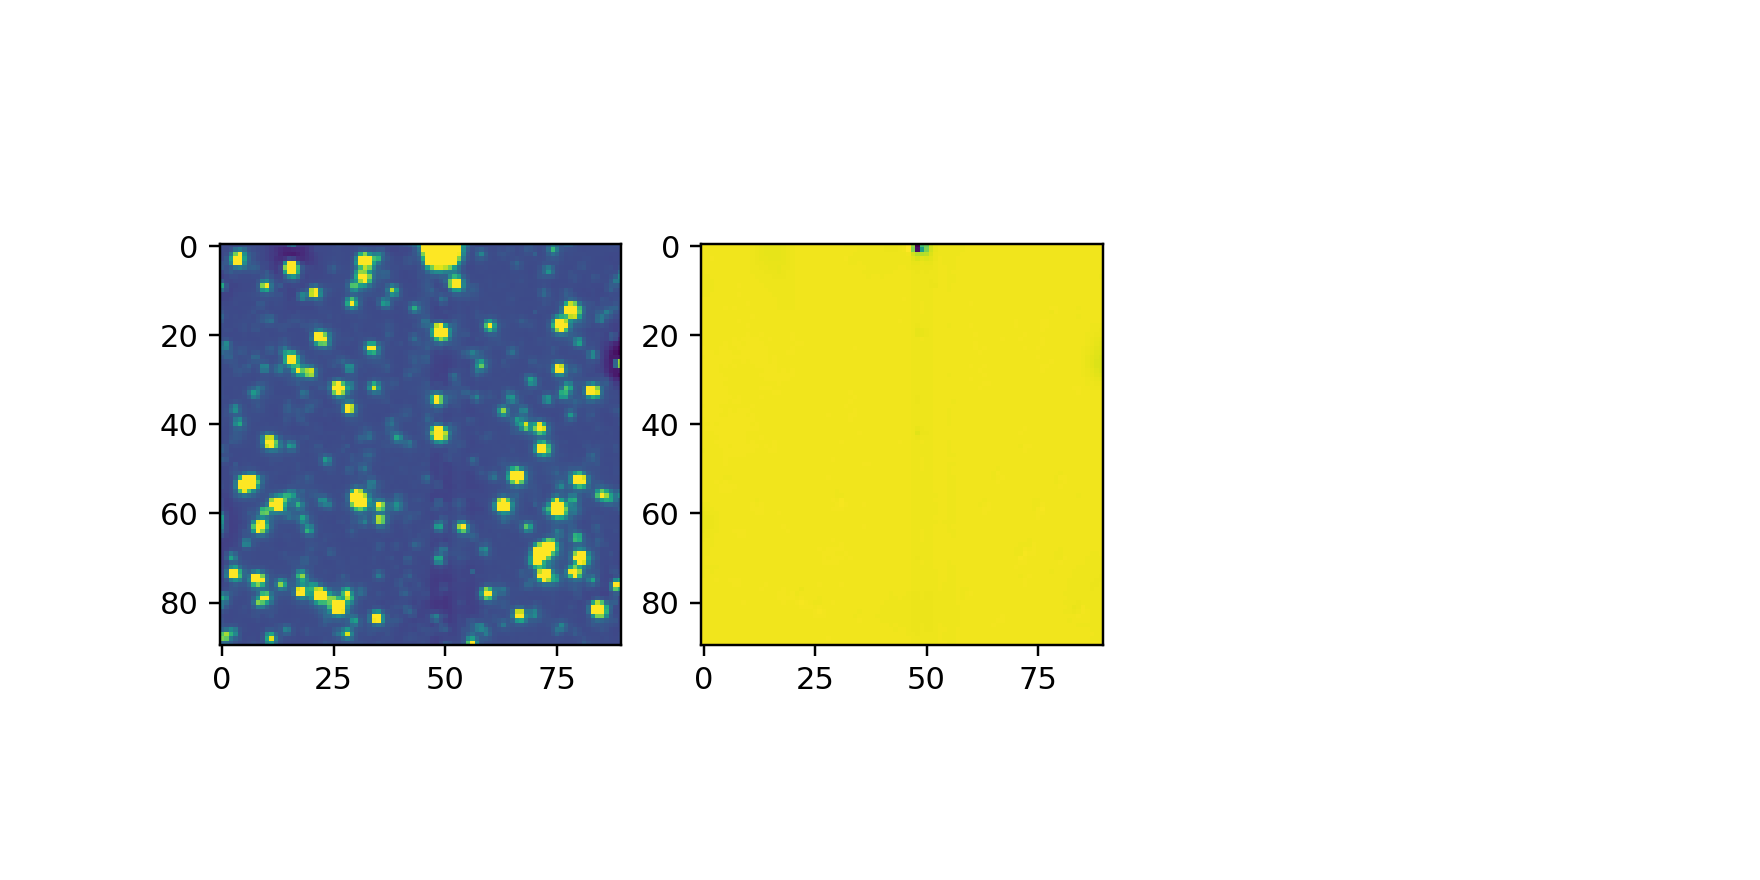

In [35]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(target,vmax=150)
plt.subplot(132)
plt.imshow(target-registered_image)

<IPython.core.display.Javascript object>


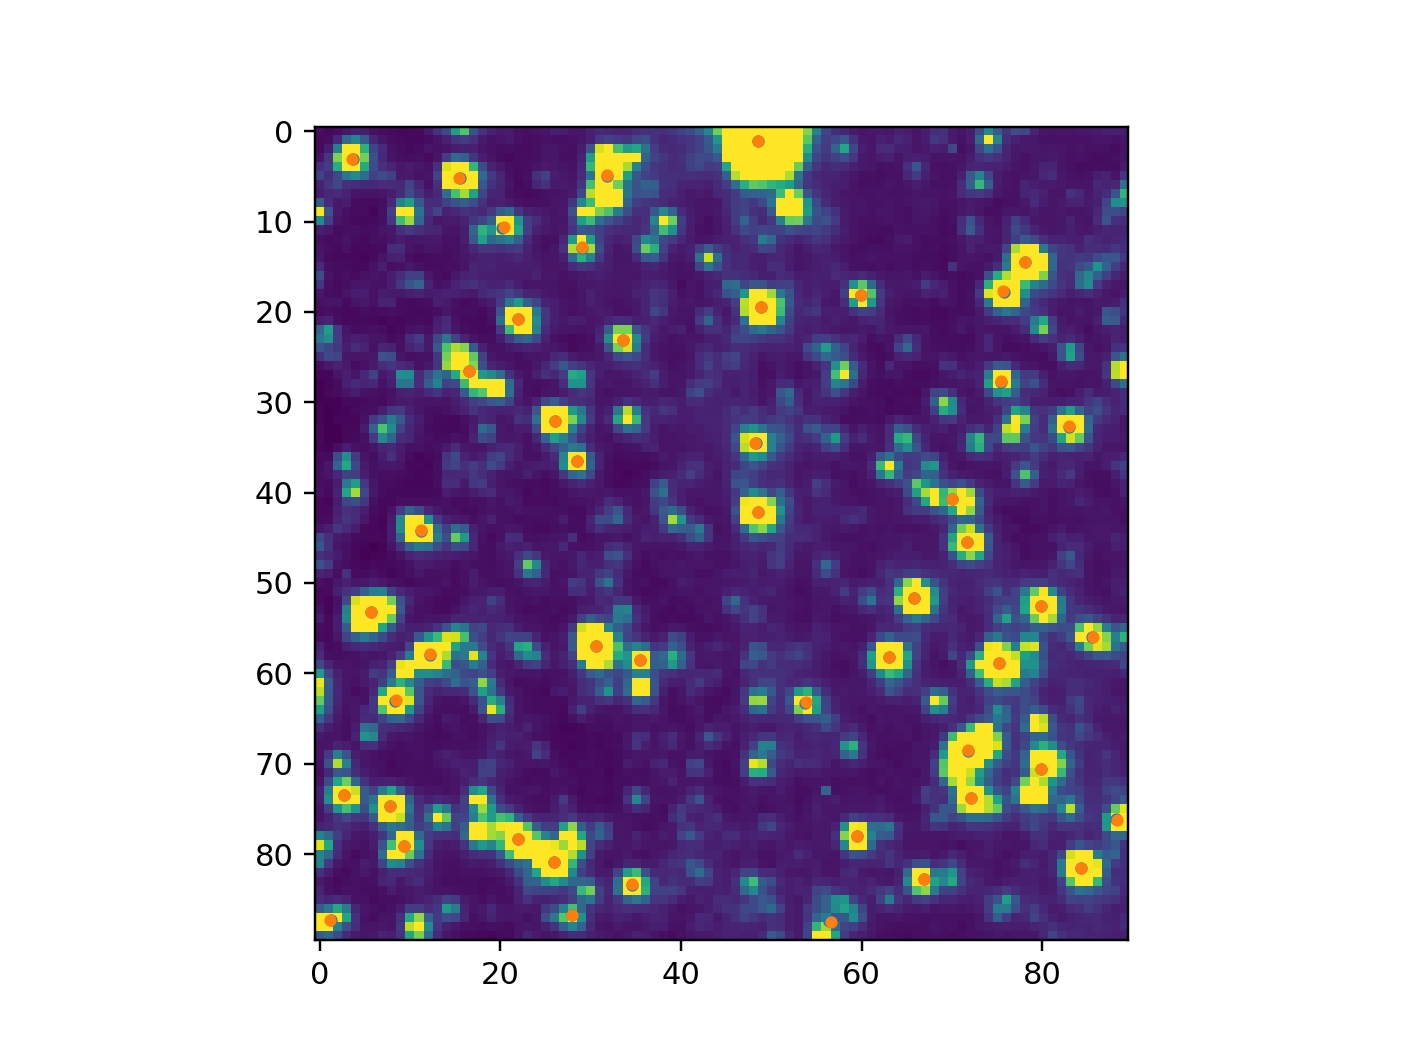

In [26]:
plt.figure()
plt.imshow(source,vmax=200)
plt.plot(source_list[:,0],source_list[:,1],'.')
plt.plot(target_list[:,0],target_list[:,1],'.')

In [59]:
cat = tr.PS1_to_TESS_mag(tess.cat)

In [334]:
PSF = tr.TESS_PRF(tess.tpf.camera,tess.tpf.ccd,20,1000,1000)
psf = PSF.locate(10,10,stampsize=(21,21))
p = psf[10:,10]

In [120]:
p.shape

(11,)

In [244]:
cat = tr.deepcopy(tess.cat)
cat = cat[np.isfinite(cat.tmag) & (cat.tmag < 18)]

In [245]:
x = cat.col; y = cat.row
distance = 10
pos = np.array([x,y]).T
cluster = DBSCAN(eps=distance,min_samples=1,n_jobs=-1).fit(pos)
labels = cluster.labels_
unique_labels = set(labels)

In [246]:
from sklearn.neighbors import KDTree

In [285]:
x = cat.col; y = cat.row
distance = 10
pos = np.array([x,y]).T
tree = KDTree(pos, leaf_size=2)              
dist, ind = tree.query(pos, k=50)  

In [248]:
def to_flux(mag):
    flux = 10**((mag-25)/-2.5)
    return flux

In [249]:
len(ind)

1911

In [266]:
x = cat.col; y = cat.row
distance = 10

def find_contamination(x,y,mag,distance=10):
    psf = tr.TESS_PRF(1,1,20,1000,1000)
    p = psf.locate(distance,distance,stampsize=(distance*2+1,distance*2+1))
    p = p[distance:,distance]
    pos = np.array([x,y]).T
    tree = KDTree(pos, leaf_size=2)              
    dist, ind = tree.query(pos, k=50)  

    dist[dist > distance] = distance

    f = to_flux(mag[ind])
    contamination = np.nansum(f[:,1:]*p[dist[:,1:].astype(int)] / f[:,0,np.newaxis],axis=1)
    return contamination 

In [267]:
c = find_contamination(x,y,cat.tmag.values)

In [268]:
c

array([8.93790648e-02, 3.67804101e-05, 8.53979402e-02, ...,
       1.52341972e+00, 1.81966071e+00, 1.25219632e-02])

In [253]:
ind.shape

(1911, 50)

In [254]:
dist.shape

(1911, 50)

In [255]:
f = to_flux(cat.tmag.values[ind])
contamination = np.nansum(f[:,1:]*p[dist[:,1:].astype(int)] / f[:,0,np.newaxis],axis=1) * 9

IndexError: index 11 is out of bounds for axis 0 with size 11

In [224]:
contamination = np.nansum(f[:,1:]*p[dist[:,1:].astype(int)] / f[:,0,np.newaxis],axis=1) * 9
i = contamination < 1

<IPython.core.display.Javascript object>


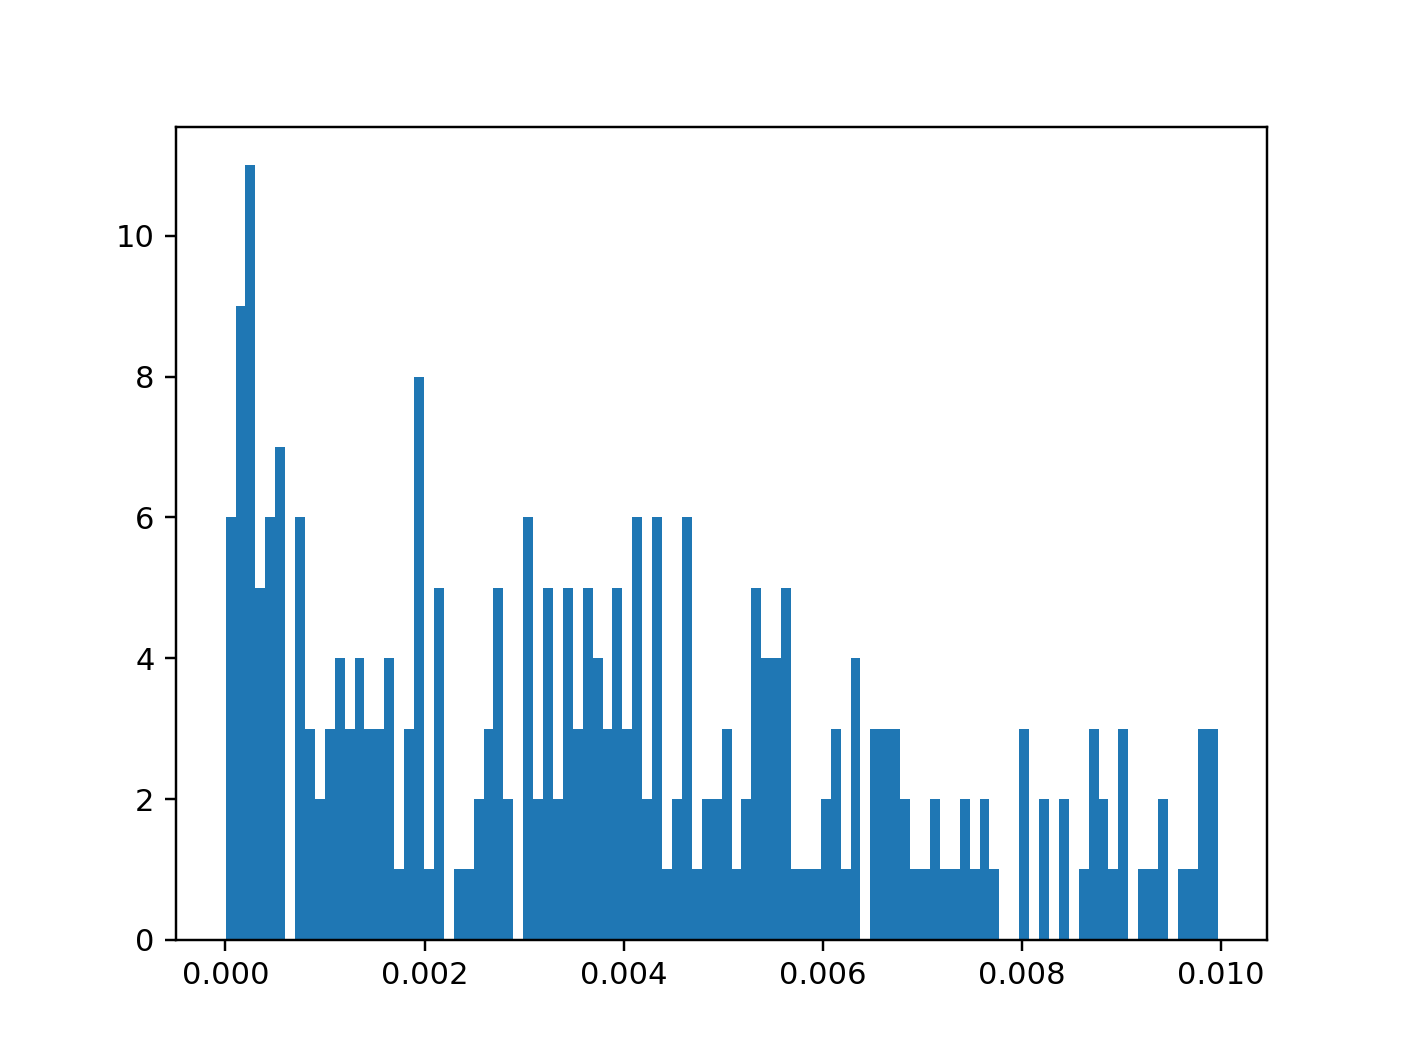

In [271]:
plt.figure()
#plt.hist(contamination[i],bins=100);
plt.hist(c[c<0.01],bins=100,alpha=1);

In [226]:
cat.tmag.values[contamination < 0.01]

array([12.52575094, 16.20500718, 14.51420934, 14.66808857, 16.29172909,
       16.86367396, 12.17382945, 12.47590072, 12.61525179, 15.55992122,
       16.60732522, 10.54870537, 14.17393048,  8.52366494, 12.92857393,
       17.86948791, 13.14091936, 11.25964972, 12.17397835, 13.0832592 ,
       13.10133692, 14.80004642, 13.39636209, 11.84301539, 14.01334546,
       11.63036149, 12.55105294, 12.35564694, 12.70021449, 13.27001835,
       11.74046619, 14.20789667, 15.32088554, 10.98894766, 14.81917572,
       11.20589329,  9.01505329, 12.96772596, 11.66082997, 11.99709768,
       14.05371011, 16.07386365, 15.88453529, 14.24520275,  9.36613013,
       12.21102594, 14.41117435, 13.03867184, 15.92674303, 14.9156013 ,
       13.08128931, 17.74462073, 15.19704442, 11.39127148, 13.21396222,
       14.92761801, 10.65554113,  6.93749188, 12.42607696, 14.54730382])

<IPython.core.display.Javascript object>


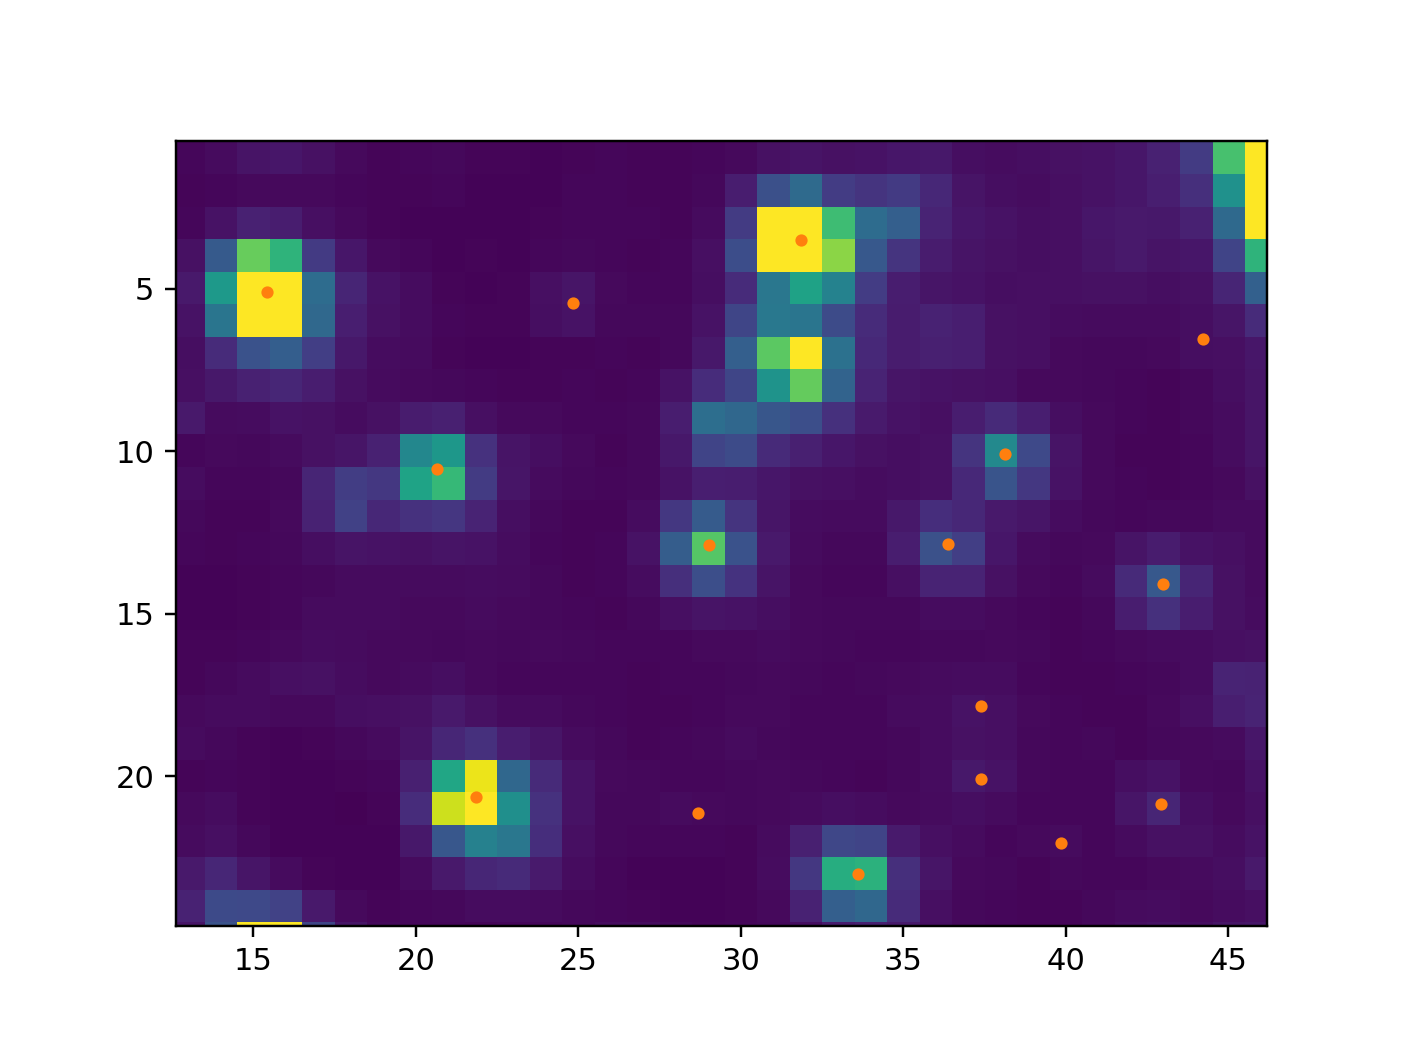

In [272]:
plt.figure()
plt.imshow(source,vmax=400)
plt.plot(x[c < 0.05],y[c < 0.05],'C1.')

In [339]:
bind = cat.tmag.values < 15
xx = x[bind]; yy = y[bind]
data = source
size = 5
hsize = (size - 1) / 2

mask = ((xx > hsize) & (xx < (data.shape[1] -1 - hsize)) &
        (yy > hsize) & (yy < (data.shape[0] -1 - hsize)))  

from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = xx[mask]  
stars_tbl['y'] = yy[mask]  

In [340]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)  
data -= median_val  

In [341]:
from astropy.nddata import NDData
nddata = NDData(data=data) 

from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=size)  

<IPython.core.display.Javascript object>


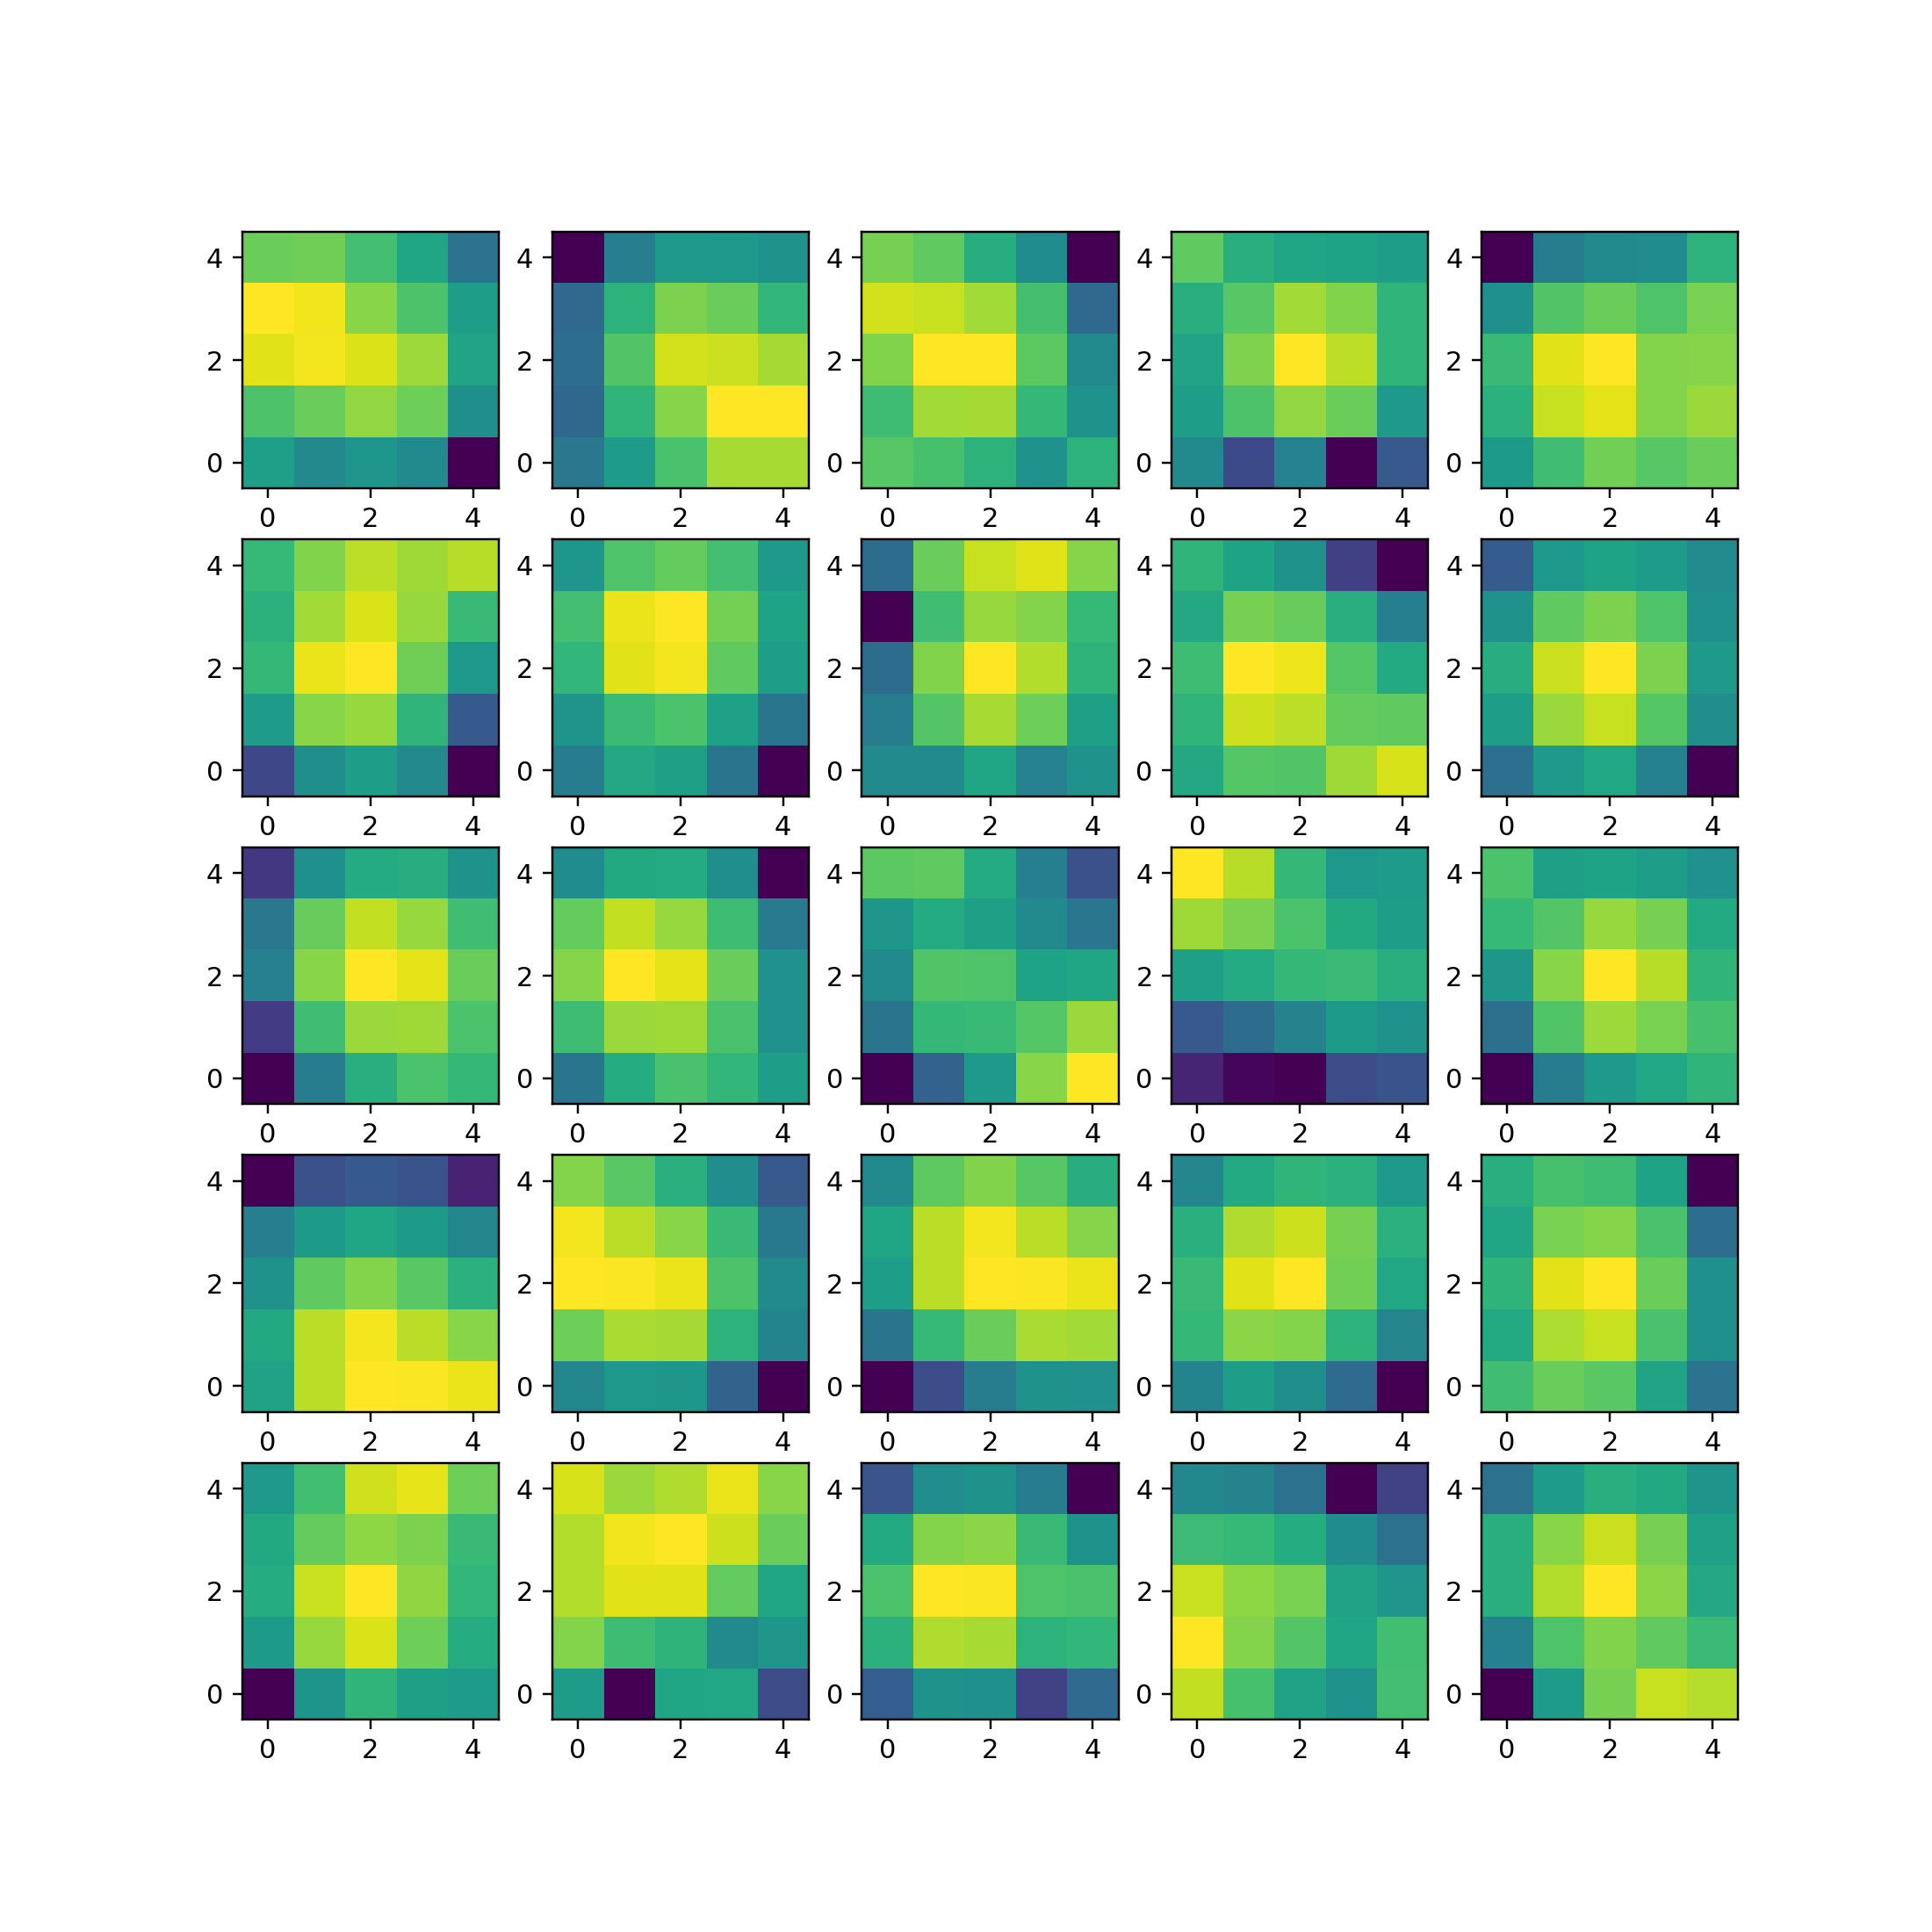

In [342]:
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [343]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  

<IPython.core.display.Javascript object>


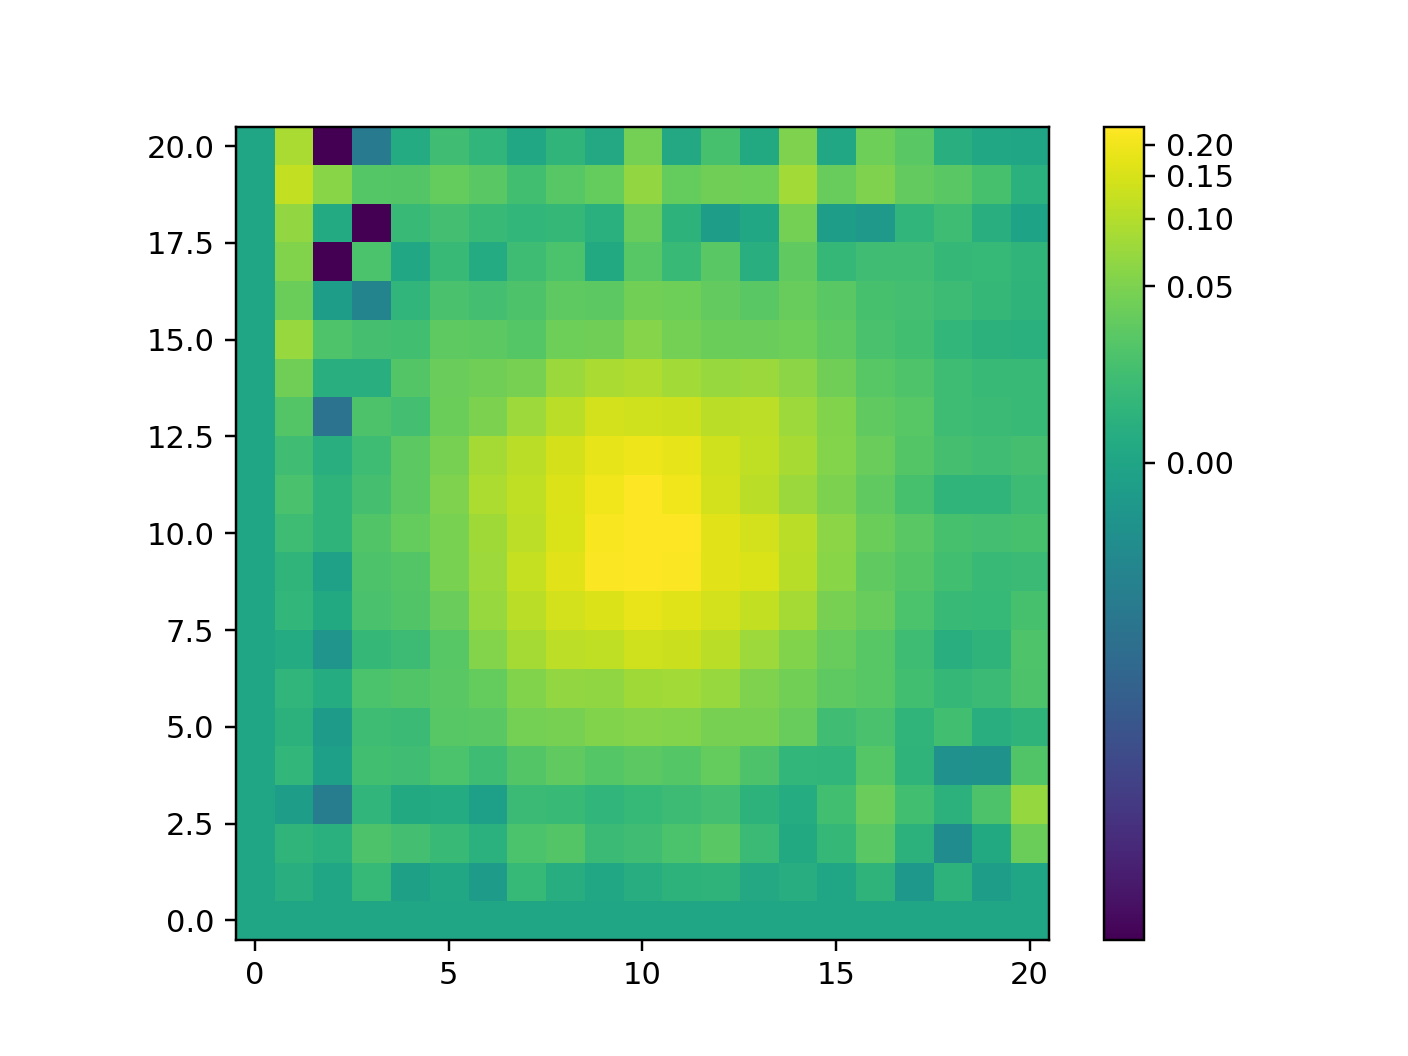

In [344]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.figure()
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [345]:
from photutils.background import LocalBackground, MMMBackground
from photutils.psf import IterativePSFPhotometry

from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from astropy.table import QTable
from photutils.detection import StarFinder

In [348]:
fit_shape = (5, 5)
finder = DAOStarFinder(3.0, 2.0)
psfphot = PSFPhotometry(epsf, fit_shape, finder=finder,
                        aperture_radius=4)

In [349]:
psfphot

In [358]:
mask = ((x > 3) & (x < (data.shape[1] -1 - 3)) &
        (y > 3) & (y < (data.shape[0] -1 - 3)))  

fit_shape = (5, )
finder = DAOStarFinder(10.0, 2.0)
finder = StarFinder(10,kernel=psf)
bkgstat = MMMBackground()
localbkg_estimator = LocalBackground(5, 15, bkgstat)
init_params = QTable()
init_params['x'] = x[mask]
init_params['y'] = y[mask]
psfphot2 = IterativePSFPhotometry(epsf, fit_shape, finder=finder,
                                  localbkg_estimator=localbkg_estimator,
                                  aperture_radius=1.5,maxiters=1)
phot = psfphot2(data, init_params=init_params)

<IPython.core.display.Javascript object>


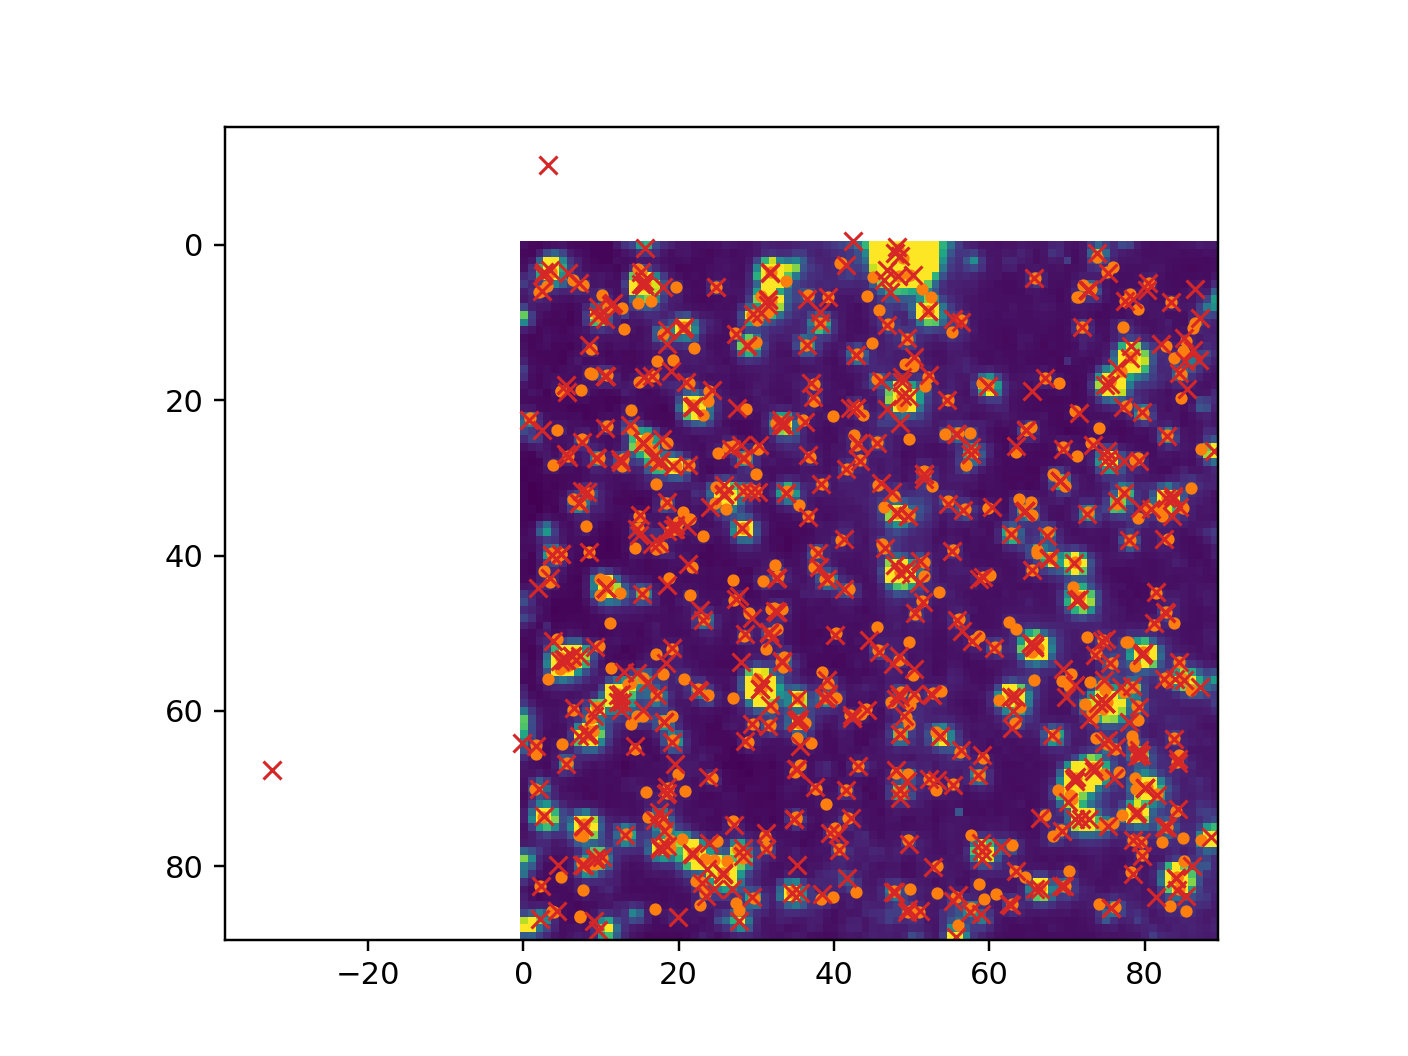

In [359]:
plt.figure()
plt.imshow(data,vmax=100)
plt.plot(phot['x_init'],phot['y_init'],'C1.')
plt.plot(phot['x_fit'],phot['y_fit'],'C3x')

<IPython.core.display.Javascript object>


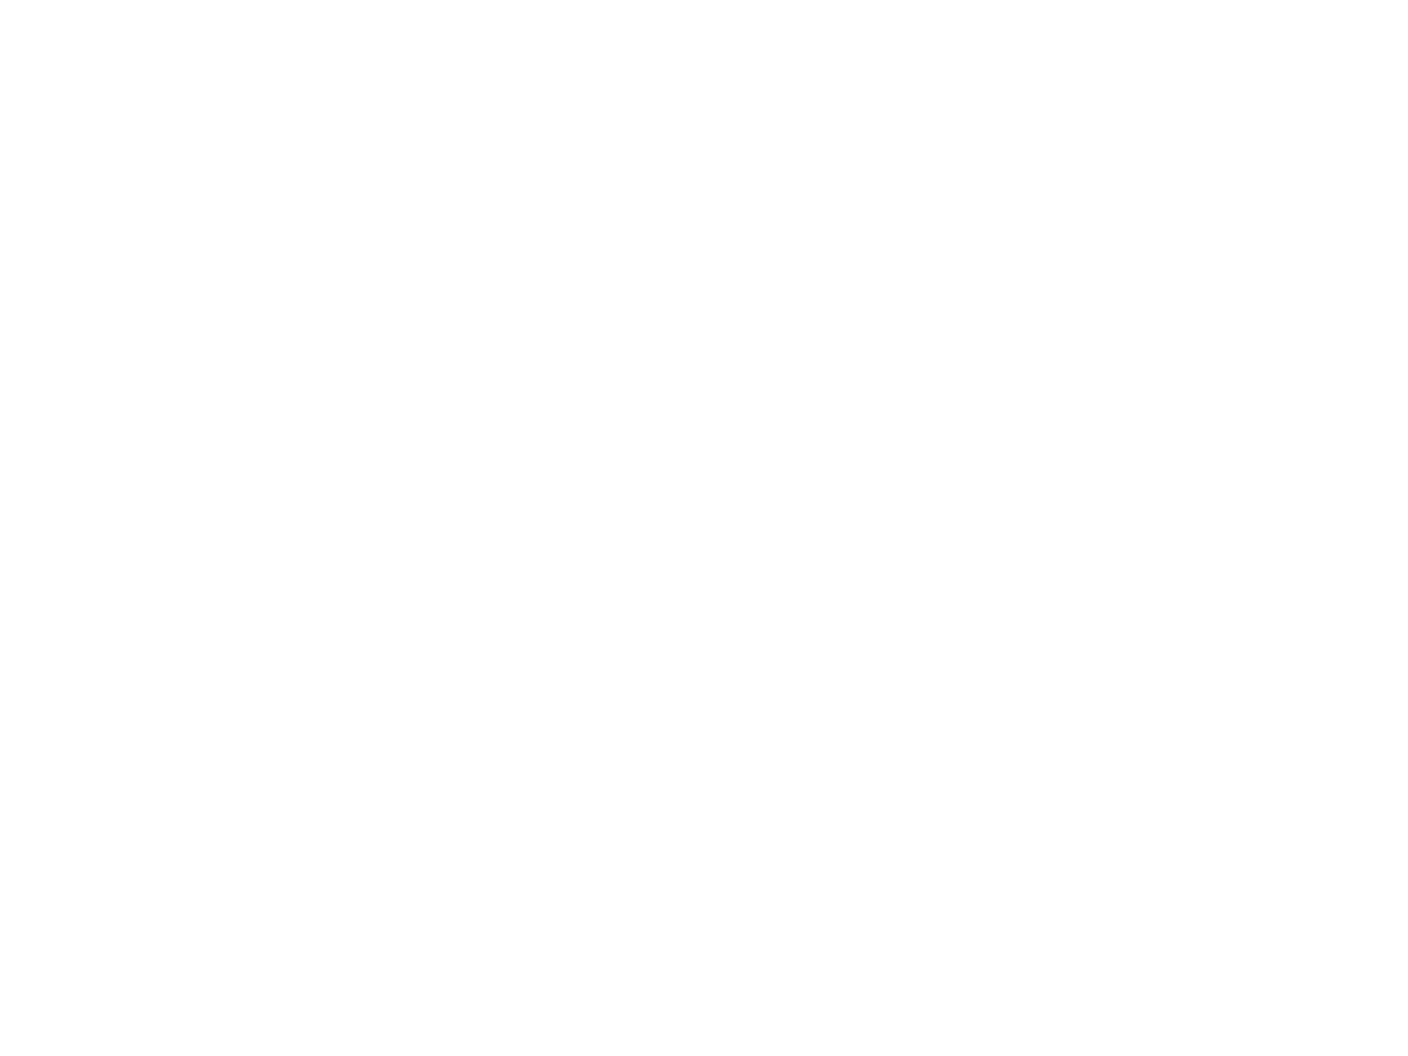

ValueError: operands could not be broadcast together with shapes (544,) (478,) 

In [325]:
plt.figure()
plt.plot(cat.tmag.values[mask],-2.5*np.log10(phot['flux_fit'].value)-cat.tmag.values[mask])

In [73]:
p = psf.locate(10,10,stampsize=(21,21))


def _spatial_group(x,y,distance=0.5,njobs=-1):
    """
    Groups events based on proximity.
    """

    pos = np.array([x,y]).T
    cluster = DBSCAN(eps=distance,min_samples=1,n_jobs=njobs).fit(pos)
    labels = cluster.labels_
    unique_labels = set(labels)
    for label in unique_labels:
        result.loc[label == labels,'objid'] = label + 1
    result['objid'] = result['objid'].astype(int)
    return result

<IPython.core.display.Javascript object>


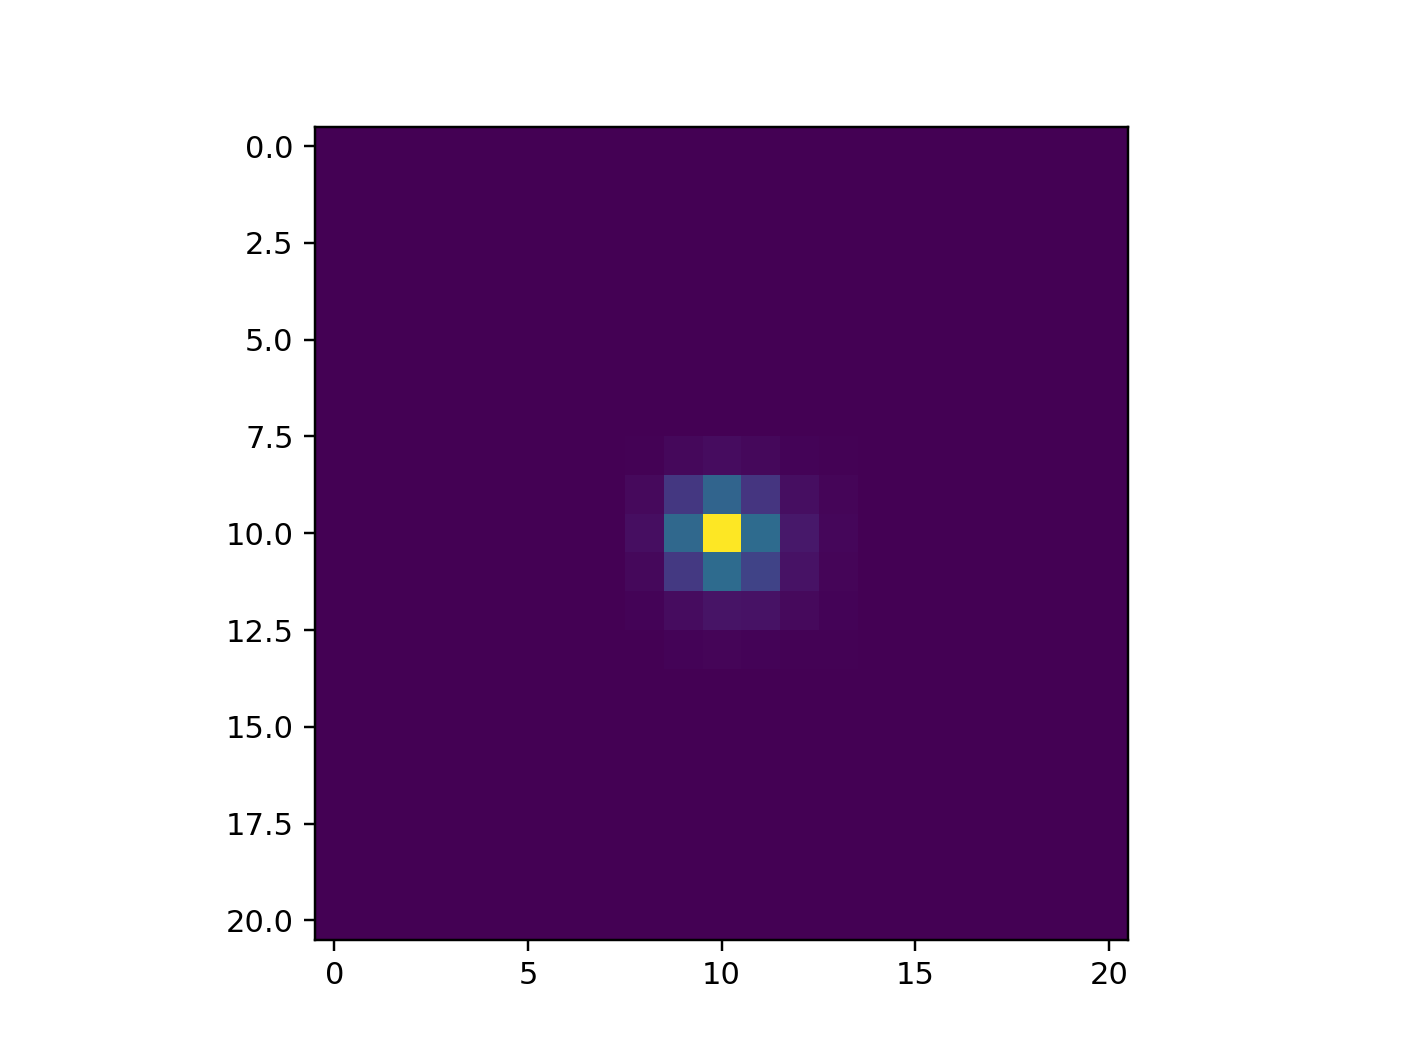

In [75]:
plt.figure()
plt.imshow(p)

In [360]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [362]:
cat

,RAJ2000,DEJ2000,objID,f_objID,Qual,e_RAJ2000,e_DEJ2000,_tab1_10,Ns,Nd,...,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags,col,row,tmag
1,120.889179,44.841279,161811208892260153,512024576,61,0.0130,0.0133,56317.095660,10,85,...,0.0106,16892216,16.8032,0.0297,15.6068,0.0312,16892216,0.417561,127.614933,17.337768
11,120.919277,44.851771,161821209193542857,637853696,76,0.0465,0.0186,56099.315266,10,100,...,NaN,98340,12.4729,0.0028,12.4904,0.0034,115000,-2.735447,124.795974,12.525751
45,120.890450,44.863567,161831208904696930,503635968,60,0.0014,0.0019,56358.213854,10,85,...,0.0090,115000,16.6021,0.0126,16.7068,0.0321,115000,1.261663,123.815156,16.996580
59,120.873386,44.858711,161831208734191116,503635968,60,0.0032,0.0030,56393.819225,9,90,...,0.0050,115000,16.2607,0.0096,16.3537,0.0060,115000,3.097914,125.228763,16.444499
61,120.883279,44.880727,161851208833477532,503635968,60,0.0185,0.0054,56442.237998,10,95,...,0.0094,115000,16.7701,0.0391,16.8259,0.0187,115000,2.892104,121.174051,17.429094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21097,120.546718,45.875455,163051205467161222,503635968,60,0.0042,0.0040,56357.396493,5,78,...,0.0101,115000,17.4823,0.0213,17.5546,0.0057,115000,87.182854,-34.975618,17.963932
21107,120.497623,45.868913,163041204976273383,503635968,60,0.0086,0.0030,56344.328194,5,78,...,0.0036,115000,16.0969,0.0018,16.2127,0.0005,115000,92.705429,-32.215455,16.257183
21123,120.426140,45.849035,163011204261579535,503635968,60,0.0018,0.0018,56356.120475,10,74,...,0.0077,115000,17.0667,0.0053,17.2330,0.0160,115000,100.297523,-26.454827,17.208534
21125,120.436056,45.850231,163021204360710975,503635968,60,0.0034,0.0033,56275.957176,10,76,...,0.0023,115000,15.4833,0.0174,15.5545,0.0123,115000,99.175522,-26.990105,15.819663


In [363]:
obs_cat = cat
radius_threshold = 2*u.arcsec
coords_obs = SkyCoord(ra=obs_cat.RAJ2000, dec=obs_cat.DEJ2000, unit='deg')
idx, d2d, d3d = coords_obs.match_to_catalog_3d(coords_obs)

In [365]:
d2d

<Angle [0., 0., 0., ..., 0., 0., 0.] deg>